In [1]:
import pandas as pd
import redis
from matplotlib import pyplot as plt
import timeit

Let's first store our training dataset in our Redis database for easy access. For this project, we'll be using the `jigsaw-toxic-comment-classification-challenge` dataset to train our NLP model in classifying toxic comments. 

You **must** first download the training dataset and extract the archive in the `data/` sub-directory of this project.

In [2]:
# Let's first do a small EDA of our training data
train_df = pd.read_csv("data/train.csv")
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Our dataset contains ~160k entries. The training dataset also comes with a testing dataset in `data/test.csv` as well as the classification results in `data/test_labels.csv`.

<Axes: >

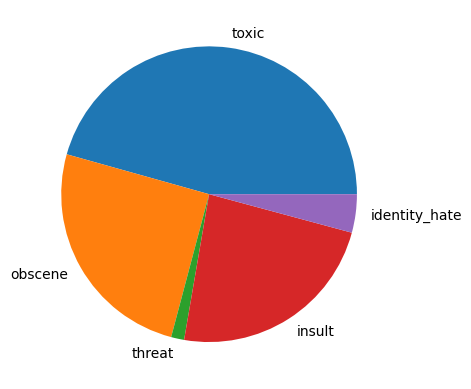

In [15]:
train_df[['toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum().plot(kind='pie')

Above you see the overall distribution of toxic comments. We'll be doing multi-label classification using NLP on those comments.

In [4]:
test_df = pd.read_csv("data/test.csv")
test_df.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


Redis is meant to be used in multiple ways and is basically a large-scale, distributed and high-performance key-value datastore. It also supports indexing and storage of JSON document, which we'll be using here to store both our **training** and **testing** datasets.

In [17]:
# connect to local redis database
r = redis.Redis(host='localhost', port=6379, decode_responses=True)

In [49]:
# let's first design the schema for both of these indexes
from redis.commands.search.field import TextField, NumericField

schema_train = (
    TextField("$.id"),
    TextField("$.comment_text"),
    NumericField("$.toxic"),
    NumericField("$.severe_toxic"),
    NumericField("$.obscene"),
    NumericField("$.threat"),
    NumericField("$.insult"),
    NumericField("$.identity_hate")
)

schema_test = (
    TextField("$.id"),
    TextField("$.comment_text")
)

In [83]:
from redis.commands.search.indexDefinition import IndexDefinition, IndexType
from redis.commands.json.path import Path

r.flushall() # clear the database first

# create training index
rs_train = r.ft("idx:train")
rs_train.create_index(
    schema_train,
    definition=IndexDefinition(
        prefix=["train:"], index_type=IndexType.JSON
    )
)
# delete any existing entries
for k in r.scan_iter("train:*"):
    r.delete(key)
    
# create training index
rs_train = r.ft("idx:test")
rs_train.create_index(
    schema_test,
    definition=IndexDefinition(
        prefix=["test:"], index_type=IndexType.JSON
    )
)
# delete any existing entries
for k in r.scan_iter("test:*"):
    r.delete(key)

Let's do a bit of data cleaning before

In [84]:
# insert the training dataset entries
start_timer = timeit.default_timer()
counter = 0
for index, row in train_df.iterrows():
    train_obj = row[['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].to_dict()
    key = "train:%d" % (index)
    r.json().set(key, Path.root_path(), train_obj)
    counter += 1
    if counter % 10000 == 0:
        print("Inserted %d training examples... still going" % counter)
print("Inserted %d examples in " % counter, timeit.default_timer() - start_timer)

Inserted 10000 examples... still going
Inserted 20000 examples... still going
Inserted 30000 examples... still going
Inserted 40000 examples... still going
Inserted 50000 examples... still going
Inserted 60000 examples... still going
Inserted 70000 examples... still going
Inserted 80000 examples... still going
Inserted 90000 examples... still going
Inserted 100000 examples... still going
Inserted 110000 examples... still going
Inserted 120000 examples... still going
Inserted 130000 examples... still going
Inserted 140000 examples... still going
Inserted 150000 examples... still going
Inserted 159571 examples in  124.32503401100007


In [85]:
# insert the testing dataset entries
start_timer = timeit.default_timer()
counter = 0
for index, row in test_df.iterrows():
    test_obj = row[['id', 'comment_text']].to_dict()
    key = "test:%d" % (index)
    r.json().set(key, Path.root_path(), test_obj)
    counter += 1
    if counter % 10000 == 0:
        print("Inserted %d testing examples... still going" % counter)
print("Inserted %d examples in " % counter, timeit.default_timer() - start_timer)

Inserted 10000 testing examples... still going
Inserted 20000 testing examples... still going
Inserted 30000 testing examples... still going
Inserted 40000 testing examples... still going
Inserted 50000 testing examples... still going
Inserted 60000 testing examples... still going
Inserted 70000 testing examples... still going
Inserted 80000 testing examples... still going
Inserted 90000 testing examples... still going
Inserted 100000 testing examples... still going
Inserted 110000 testing examples... still going
Inserted 120000 testing examples... still going
Inserted 130000 testing examples... still going
Inserted 140000 testing examples... still going
Inserted 150000 testing examples... still going
Inserted 153164 examples in  112.42333190900013


In [86]:
# checking to make sure every entries was inserted into database
r.dbsize()

312735

Now that we have the training and testing dataset into our Redis database, we'll define our neural network.

We first need to convert the GloVe embeddings into the word2vec format. We use `gensim` glove2word2vec function to do so.

In [87]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove_path = "data/glove.6B.100d.txt"
word2vec_path = "data/glove.word2vec"
glove2word2vec(glove_path, word2vec_path)

/tmp/ipykernel_871/3567386615.py:4: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_path, word2vec_path)


(400000, 100)